# Trump vs Obama vs Biden: Twitter WordCloud Observations

## by Hiten Naran

## Overview of project:

The purpose of this project is to generate insights by diving into the most popular tweeted words and hashtags used by Barack Obama, Donalod Trump and Joe Biden.

The project is broken down into 7 sections:

1. Scraping tweet data from Obama, Trump and Biden's Twitter feeds via the "GetOldTweets3' library
2. Assessing the data in order to identify what cleaning steps are required.
3. Cleaning the dataset in order to make it fit for conducting exploratory analysis
4. Exploratory analysis into the dataset and uncover learnings.
5. Export cleaned DataFrame to a GoogleSheet
6. Export DataFrame to csv for DataStudio usage
7. Export original cleaned Dataset

In [1]:
import tweepy
import pandas as pd
import json
import time
import datetime as dt
import csv
import GetOldTweets3 as got;
import glob
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.gridspec as gridspec
import re

### 1. Getting started: Scraping tweets from Obama and Trumps timelines 

Given the limitations of only being able to obtain up to 3,200 tweets via basic Twitter API access. Working with the 
'GetOldTweets3' library is a useful hack for scraping an inifinite amount of tweets as we're able to obtain the neccessary tweet data through web scraping the twitter user feeds versus accessing through an API connection. 

As long as the tweet is still visible on a user's timeline, we can scrape and obtain the data visibily associated with the said tweet i.e. (retweets, time posted, mentions etc)

References:

https://medium.com/@AIY/getoldtweets3-830ebb8b2dab

https://pypi.org/project/GetOldTweets3/

In [1166]:
#The below function will enable the scraping of a user's twitter feed.
#A list of Twitter usernames needs to br provided as the first parameter 

#start_date and end_date needs to be provided in the following format "YYYY-MM-DD". This will enable the function to
#scrape tweets which fall within the start_date and end_date range

def get_tweets(username, start_date, end_date):
   
    # specifying tweet search criteria 
    tweetCriteria = got.manager.TweetCriteria().setUsername(username)\
                          .setSince(start_date)\
                          .setUntil(end_date)
    
    # scraping tweets based on criteria
    tweet = got.manager.TweetManager.getTweets(tweetCriteria)
    
    # creating list of tweets with the tweet attributes 
    # specified in the list comprehension
    text_tweets = [[tw.username,
                tw.id,
                tw.text,
                tw.date,
                tw.retweets,
                tw.favorites,
                tw.mentions,
                tw.hashtags] for tw in tweet]
    
    # creating dataframe, assigning column names to list of
    # tweets corresponding to tweet attributes
    tweet_df = pd.DataFrame(text_tweets, 
                            columns = ['User', 'tweet_id', 'Text','Date',      'Favorites', 'Retweets', 'Mentions', 'HashTags'])
    
    return tweet_df

Given how we are looking to scrape tweet level data all the way from the start of 2008! To ensure the function we built doesn't crash midway. The looping script below will scrape the Twitter user feeds at a yearly level and store these in a CSV format.

With the handy glob method we can eventually bring all the downloaded csv files together into a single DataFrame!

In [467]:
# Defining the list of Twitter users we want to scrape tweet level data from
user_names = ['JoeBiden', "realDonaldTrump", "BarackObama"]

#List of year ranges we want to extrapolate tweets from:
year_range = [["2020-01-01", "2020-09-15"], ["2019-01-01", "2020-01-01"], ["2018-01-01", "2019-01-01"], ["2017-01-01", "2018-01-01"], ["2016-01-01", "2017-01-01"], ["2015-01-01", "2016-01-01"], ["2014-01-01", "2015-01-01"], ["2013-01-01", "2014-01-01"], ["2012-01-01", "2013-01-01"], ["2011-01-01", "2012-01-01"], ["2010-01-01", "2011-01-01"], ["2009-01-01", "2010-01-01"], ["2008-01-01", "2009-01-01"]]

In [468]:
#Start scraping Twitter user feeds and save the data into yearly csv files 
for year in year_range:
    tweet_df = get_tweets(user_names, 
                     start_date = year[0], 
                     end_date = year[1])
    
    year_name = year[0][:4]
    file_name = '{user_names}_{year_name}.csv'.format(year_name = year_name, user_names = user_names)
    tweet_df.to_csv(file_name, index = False)

In [6]:
#Now we need to import the yearly csv files and store in a list which we can use with the handy Glob method
files = glob.glob('*.csv')

#Now we need to convert the csv files into DataFrames and store these in a list
list_df = []

for file in files:
    df = pd.read_csv(file)
    list_df.append(df)

In [7]:
#Concantenate the list of DataFrames into a single big DataFrame and Voila!
user_names_df = pd.concat(list_df)

### 2. Assess the data:

1. We have some missing tweet text values, which is due to the fact that they are simply image tweets.
2. Around 10K of the tweets out of 56K include hashtags
3. Around 60% of tweets (~3K tweets) include a mention
4. The Date column is currently formatted as a string which needs to be converted into DateTime.
5. Need columns for year, month, day and hour
6. 'Favorites' and 'Retweets' need to be reformatted into integers.

In [8]:
user_names_df.shape

(56340, 8)

In [9]:
user_names_df.head()

,User,tweet_id,Text,Date,Favorites,Retweets,Mentions,HashTags
0,JoeBiden,1305648774157565952,".@realDonaldTrump, you know what’s actually th...",2020-09-14 23:25:00+00:00,35588,206086,@realDonaldTrump,NaN
1,JoeBiden,1305608509229207552,Science knows.,2020-09-14 20:45:00+00:00,24930,115776,NaN,NaN
2,JoeBiden,1305605992483258371,"Folks, it all comes down to this. We have just...",2020-09-14 20:35:00+00:00,7974,31128,NaN,NaN
3,JoeBiden,1305578058326343683,Amy Poehler and @MayaRudolph know a thing or t...,2020-09-14 18:44:00+00:00,3479,15652,@MayaRudolph @HillaryClinton @KamalaHarris,NaN
4,JoeBiden,1305559162080747525,Climate change is the existential challenge th...,2020-09-14 17:28:55+00:00,4318,13714,NaN,NaN


In [10]:
#No duplicates
user_names_df.duplicated().value_counts()

False    56340
dtype: int64

In [11]:
# We have some missing tweet text values, which is due to the fact that they are simply image tweets.
# Around 10K out of 56K tweets include hashtags
# Around 55% of tweets (~34K tweets) include a mention

user_names_df.isnull().sum()

User             0
tweet_id         0
Text           801
Date             0
Favorites        0
Retweets         0
Mentions     33865
HashTags     45643
dtype: int64

In [12]:
user_names_df[user_names_df.Text.isnull()]

,User,tweet_id,Text,Date,Favorites,Retweets,Mentions,HashTags
306,JoeBiden,1295534984338509824,NaN,2020-08-18 01:36:24+00:00,1073,5929,NaN,NaN
309,JoeBiden,1295529965589532673,NaN,2020-08-18 01:16:28+00:00,1741,8268,NaN,NaN
1500,JoeBiden,1144416186702204928,NaN,2019-06-28 01:24:15+00:00,268,1330,NaN,NaN
1802,JoeBiden,1114555617245634566,NaN,2019-04-06 15:49:01+00:00,370,3618,NaN,NaN
1841,JoeBiden,1089240523884425216,NaN,2019-01-26 19:15:52+00:00,723,3802,NaN,NaN
...,...,...,...,...,...,...,...,...
4024,realDonaldTrump,1214230768278478848,NaN,2020-01-06 17:02:29+00:00,26037,105327,NaN,NaN
4025,realDonaldTrump,1214230745176322048,NaN,2020-01-06 17:02:23+00:00,18562,67961,NaN,NaN
4038,realDonaldTrump,1213316570606428160,NaN,2020-01-04 04:29:47+00:00,23175,155361,NaN,NaN
4048,realDonaldTrump,1212924762827046918,NaN,2020-01-03 02:32:53+00:00,156411,761904,NaN,NaN


In [13]:
user_names_df.describe()

,User,tweet_id,Text,Date,Favorites,Retweets,Mentions,HashTags
count,56340,56340,55539,56340,56340,56340,22475,10697
unique,3,56340,54939,55727,17130,23503,14334,3279
top,realDonaldTrump,480246593149353985,MAKE AMERICA GREAT AGAIN!,2019-04-29 21:35:32+00:00,0,0,@realDonaldTrump,#Trump2016
freq,41479,1,64,5,580,772,1270,438


In [14]:
user_names_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56340 entries, 0 to 811
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   User       56340 non-null  object
 1   tweet_id   56340 non-null  object
 2   Text       55539 non-null  object
 3   Date       56340 non-null  object
 4   Favorites  56340 non-null  object
 5   Retweets   56340 non-null  object
 6   Mentions   22475 non-null  object
 7   HashTags   10697 non-null  object
dtypes: object(8)
memory usage: 3.9+ MB


In [15]:
#Really interesting to see how much more of an extensive tweeter Trump is in relation to Obama and Biden
user_names_df.User.value_counts()

realDonaldTrump    41479
BarackObama         9506
JoeBiden            5355
Name: User, dtype: int64

### 3. Date Cleaning:

**Cleaning task 1.** Convert 'Date' column from string to datetime format

In [16]:
#Start by making a copy which we'll work with for cleaning purposes from here on forth
user_names_df_clean = user_names_df.copy()

In [17]:
user_names_df_clean['Date'] = user_names_df_clean['Date'].astype('datetime64[ns]') 

**Test:** Let's check that 'Date' column has been converted to DateTime

In [18]:
user_names_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56340 entries, 0 to 811
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   User       56340 non-null  object        
 1   tweet_id   56340 non-null  object        
 2   Text       55539 non-null  object        
 3   Date       56340 non-null  datetime64[ns]
 4   Favorites  56340 non-null  object        
 5   Retweets   56340 non-null  object        
 6   Mentions   22475 non-null  object        
 7   HashTags   10697 non-null  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 3.9+ MB


**Cleaning task 2.** Create additional columns of: Year, Month, Day, Hour

In [19]:
user_names_df_clean['Year'] = user_names_df_clean.Date.dt.year
user_names_df_clean['Month'] = user_names_df_clean.Date.dt.month
user_names_df_clean['Day'] = user_names_df_clean.Date.dt.day
user_names_df_clean['Hour'] = user_names_df_clean.Date.dt.hour

**Test:** Let's check that the number of yearly values matches up with the number of rows in the original csv files that were downloaded

In [20]:
user_names_df_clean.tail()

,User,tweet_id,Text,Date,Favorites,Retweets,Mentions,HashTags,Year,Month,Day,Hour
807,JoeBiden,189383473717460992,I’m for the Buffett Rule because it just makes...,2012-04-09 16:05:13,471,51,NaN,NaN,2012,4,9,16
808,JoeBiden,189343279140184065,"In NH on 4/12, the Vice President will give hi...",2012-04-09 13:25:30,52,6,NaN,NaN,2012,4,9,13
809,JoeBiden,189339650610036736,News for you this morning: VP Biden will speak...,2012-04-09 13:11:05,54,5,NaN,#BuffettRule,2012,4,9,13
810,JoeBiden,189287350034104320,Campaign staff will run this account to keep y...,2012-04-09 09:43:15,71,37,NaN,NaN,2012,4,9,9
811,JoeBiden,189287227321356289,We're excited to announce that @JoeBiden is be...,2012-04-09 09:42:46,83,20,@JoeBiden,NaN,2012,4,9,9


In [21]:
user_names_df_clean.Year.value_counts()

2013    10342
2015     9041
2014     8179
2019     6562
2020     6286
2016     4952
2018     3209
2017     2427
2011     2080
2012     1956
2010      827
2009      271
2008      208
Name: Year, dtype: int64

**Cleaning task 3.** Change 'tweet_id' column name to 'Tweet_id'

In [22]:
user_names_df_clean.rename(columns = {'tweet_id': 'Tweet_id'}, inplace = True)

**Test:** Test to see all columns titles have been capitalised

In [23]:
user_names_df_clean.head()

,User,Tweet_id,Text,Date,Favorites,Retweets,Mentions,HashTags,Year,Month,Day,Hour
0,JoeBiden,1305648774157565952,".@realDonaldTrump, you know what’s actually th...",2020-09-14 23:25:00,35588,206086,@realDonaldTrump,NaN,2020,9,14,23
1,JoeBiden,1305608509229207552,Science knows.,2020-09-14 20:45:00,24930,115776,NaN,NaN,2020,9,14,20
2,JoeBiden,1305605992483258371,"Folks, it all comes down to this. We have just...",2020-09-14 20:35:00,7974,31128,NaN,NaN,2020,9,14,20
3,JoeBiden,1305578058326343683,Amy Poehler and @MayaRudolph know a thing or t...,2020-09-14 18:44:00,3479,15652,@MayaRudolph @HillaryClinton @KamalaHarris,NaN,2020,9,14,18
4,JoeBiden,1305559162080747525,Climate change is the existential challenge th...,2020-09-14 17:28:55,4318,13714,NaN,NaN,2020,9,14,17


**Cleaning task 4.** Change the format of columns 'Favorites' and 'Retweets' to integer

In [24]:
user_names_df_clean[['Favorites', 'Retweets']] = user_names_df_clean[['Favorites', 'Retweets']].apply(pd.to_numeric)

**Test:** Have the column types changed

In [25]:
user_names_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56340 entries, 0 to 811
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   User       56340 non-null  object        
 1   Tweet_id   56340 non-null  object        
 2   Text       55539 non-null  object        
 3   Date       56340 non-null  datetime64[ns]
 4   Favorites  56340 non-null  int64         
 5   Retweets   56340 non-null  int64         
 6   Mentions   22475 non-null  object        
 7   HashTags   10697 non-null  object        
 8   Year       56340 non-null  int64         
 9   Month      56340 non-null  int64         
 10  Day        56340 non-null  int64         
 11  Hour       56340 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(5)
memory usage: 5.6+ MB


In [26]:
#Looks good
user_names_df_clean.describe()

,Favorites,Retweets,Year,Month,Day,Hour
count,5.634000e+04,5.634000e+04,56340.000000,56340.000000,56340.000000,56340.000000
mean,6.409913e+03,2.749853e+04,2015.476447,6.539670,15.717164,13.626589
std,1.589376e+04,6.847600e+04,2.775327,3.412266,8.827861,7.058853
min,0.000000e+00,0.000000e+00,2008.000000,1.000000,1.000000,0.000000
25%,5.100000e+01,4.700000e+01,2013.000000,4.000000,8.000000,10.000000
50%,6.440000e+02,1.047500e+03,2015.000000,7.000000,16.000000,15.000000
75%,9.439000e+03,3.951850e+04,2018.000000,9.000000,23.000000,19.000000
max,1.564266e+06,4.340944e+06,2020.000000,12.000000,31.000000,23.000000


### 4. Exploratory Data Analysis:

**Key questions:**

1. How frequently did Trump, Biden Obama tweet over the years? Can we see interesting trends?
2. What were the most retweeted tweets between Trump, Biden and Obama? Any trends?
3. What are the most popular hashtags used between Trump, Biden and Obama?
4. What are the most popular words used between Trump, Biden and Obama within their tweets?

**1. How frequently did Trump, Obama and Biden tweet over the years? Can we see interesting trends during their presidency stints.**

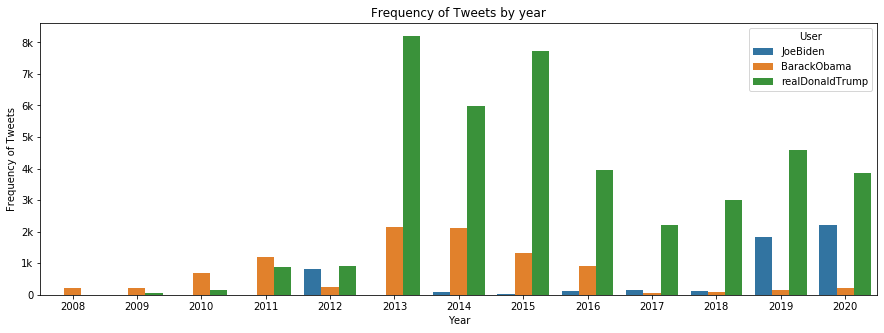

In [27]:
plt.figure(figsize = (15, 5));
palette ={"JoeBiden": "C0", "BarackObama": "C1", "realDonaldTrump": "C2"}
sb.countplot(data = user_names_df_clean, x = 'Year', hue = 'User', palette = palette, hue_order = ["JoeBiden", "BarackObama", "realDonaldTrump"]);
plt.ylabel('Frequency of Tweets');
plt.title('Frequency of Tweets by year');
plt.yticks(np.arange(0, 8001, 1000), [0,'1k','2k','3k','4k','5k','6k','7k','8k']);

**Obervations:**

 - Obama was quite an active tweeter during his second presidential term (2013 - 2016), peaking during  the early years 2013 - 2014. However since leaving office, he has become quite a passive tweeter
 - Trump on the hand has been a highly active tweeter with the frequency of usage exploding from 2013 onwards.
 - We can see that Biden only started tweeting from 2012 onwards. Whilst we can see that he was quite an active tweeter during 2012, he very rarely tweeted from 2013 through to 2018 where he spent the majority of this period serving as the Vice President.

**2. What were the most retweeted tweets between Trump, Biden and Obama?**

In support of this question let's also look at the following:

 - retweets by year between Obama, Biden and Trump
 - retweets / number of tweets by year between Obama, Biden Trump

In [28]:
#We'll need to do some cleaning in order to answer the supporting questions:

#Groupy to obtain sum of retweets by year
tweet_retweet = user_names_df_clean.groupby(['User', 'Year']).Retweets.sum().reset_index()

#Groupby to obtain the frequency of tweets by year
tweet_frequency = user_names_df_clean[['User', 'Year', 'Tweet_id']].groupby(['User', 'Year']).Tweet_id.count().reset_index()
tweet_frequency.rename(columns = {'Tweet_id': 'Tweet_frequency'}, inplace = True)

#Merge the two DataFrames so we get retweets and frequency of tweets by year
tweet_frequency_retweet = pd.merge(tweet_retweet, tweet_frequency)

#Create additional column which calculates the average retweet per tweet ratio
tweet_frequency_retweet['Retweet_per_Tweet_ratio'] = tweet_frequency_retweet.Retweets / tweet_frequency_retweet.Tweet_frequency

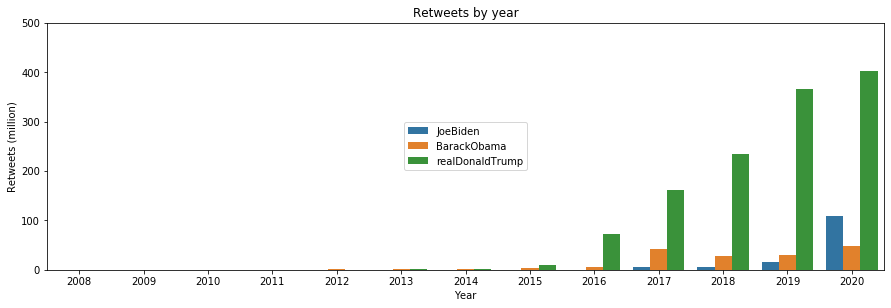

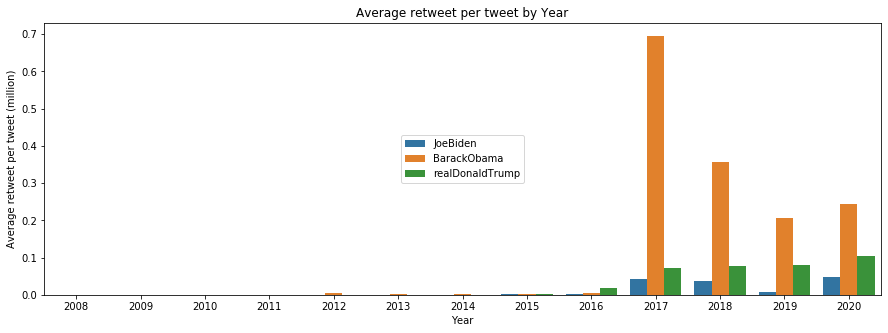

In [29]:
plt.figure(figsize = (15, 10));

palette ={"JoeBiden": "C0", "BarackObama": "C1", "realDonaldTrump": "C2"}

#Plot retweets by year
plt.subplot(2, 1, 1)
sb.barplot(data = tweet_frequency_retweet, x = 'Year', y = 'Retweets', hue = 'User', palette = palette, hue_order = ["JoeBiden", "BarackObama", "realDonaldTrump"]);
plt.title('Retweets by year');
label_range = np.arange(0, 550, 100);
plt.ylim(0, 500000000);
plt.yticks(label_range * 1000000, label_range);
plt.ylabel('Retweets (million)');
plt.legend(loc='center');

#Plot Retweet per Tweet ratio by year
plt.figure(figsize = (15, 5));
sb.barplot(data = tweet_frequency_retweet, x = 'Year', y = 'Retweet_per_Tweet_ratio', hue = 'User', palette = palette, hue_order = ["JoeBiden", "BarackObama", "realDonaldTrump"]);
plt.ylabel('Average retweet per tweet (million)');
label_range_2 = np.arange(0, 8, 1);
plt.yticks(label_range_2 * 100000, label_range_2 / 10);
plt.title('Average retweet per tweet by Year');
plt.legend(loc='center');

**Observations:**

 - Although in absolute numbers Trump has been able to generate more retweets per year across his tweets. This can be explained away due to Trump being a much active tweeter as we saw in the first section of this exploratory analysis.
 - Though If we look at the average number of retweets per tweet by year, we can see Obama had far higher numbers. It's really interesting to see how his average retweet per tweet numbers really exploded from 2016 onwards, just as his second presidential term ended. This is also when he became a more passive tweeted. 

**Let's get back to analysing the most retweeted tweets from Obama, Trump and Biden**

In [72]:
#This will enable us to see the full length of the tweets
pd.set_option('display.max_colwidth', None)

#Create individual DataFrames for Obama, Trump and Biden
obama_df = user_names_df_clean[user_names_df_clean.User == 'BarackObama']
trump_df = user_names_df_clean[user_names_df_clean.User == 'realDonaldTrump']
biden_df = user_names_df_clean[user_names_df_clean.User == 'JoeBiden']

#Sort dataframes in order of most retweeted and drop tweets without text
obama_retweet_df = obama_df.sort_values(by = ['Retweets'], ascending = False).dropna(subset = ['Text'])
trump_retweet_df = trump_df.sort_values(by = ['Retweets'], ascending = False).dropna(subset = ['Text'])
biden_retweet_df = biden_df.sort_values(by = ['Retweets'], ascending = False).dropna(subset = ['Text'])

Top retweeted Obama tweets:

In [81]:
obama_retweet_df[['Text', 'Year', 'Retweets']].reset_index().head(250).drop(columns = ['index'])

,Text,Year,Retweets
0,"""No one is born hating another person because of the color of his skin or his background or his religion...""",2017,4340944
1,Kobe was a legend on the court and just getting started in what would have been just as meaningful a second act. To lose Gianna is even more heartbreaking to us as parents. Michelle and I send love and prayers to Vanessa and the entire Bryant family on an unthinkable day.,2020,4019218
2,"In every scene, you are my star, @MichelleObama! Happy birthday, baby!",2020,2737299
3,My statement on the death of George Floyd:,2020,1936262
4,"John McCain is an American hero & one of the bravest fighters I've ever known. Cancer doesn't know what it's up against. Give it hell, John.",2017,1935819
...,...,...,...
245,This is the Joe I know.,2020,165470
246,"Four years ago, @MichelleObama and I had the privilege to host Lt. Cmdr. Dan Cnossen and his fellow Paralympians and Olympians at the White House. Today, we’re so proud of him for winning gold and silver - while still representing the red, white, and blue.",2018,165251
247,"Until all of us stand up and insist on holding public officials accountable for changing our gun laws, these tragedies will keep happening:",2019,165153
248,"In Singapore with young people who are advocating for education, empowering young women, and getting involved all over Southeast Asia with a profoundly optimistic commitment to building the world they want to see.",2018,163859


Top retweeted Trump tweets:

In [78]:
trump_retweet_df[['Text', 'Year', 'Retweets']].reset_index().head(250).drop(columns = ['index'])

,Text,Year,Retweets
0,"A$AP Rocky released from prison and on his way home to the United States from Sweden. It was a Rocky Week, get home ASAP A$AP!",2019,821991
1,The United States of America will be designating ANTIFA as a Terrorist Organization.,2020,801466
2,CHINA!,2020,775247
3,"All is well! Missiles launched from Iran at two military bases located in Iraq. Assessment of casualties & damages taking place now. So far, so good! We have the most powerful and well equipped military anywhere in the world, by far! I will be making a statement tomorrow morning.",2020,721520
4,"Kobe Bryant, despite being one of the truly great basketball players of all time, was just getting started in life. He loved his family so much, and had such strong passion for the future. The loss of his beautiful daughter, Gianna, makes this moment even more devastating....",2020,702721
...,...,...,...
245,"The only reason the U.S. has reported one million cases of CoronaVirus is that our Testing is sooo much better than any other country in the World. Other countries are way behind us in Testing, and therefore show far fewer cases!",2020,250271
246,"If Illegal Immigrants are unhappy with the conditions in the quickly built or refitted detentions centers, just tell them not to come. All problems solved!",2019,250068
247,"I feel more and more confident that our economy is in the early stages of coming back very strong. Not everyone agrees with me, but I have little doubt. Watch for September, October, November. Next year will be one of the best ever, and look at the Stock Market NOW!",2020,249952
248,دولت ایران باید به گروه‌های حقوق بشر اجازه بدهد حقیقت کنونی اعتراضات در جریان مردم ایران را نظارت کرده و گزارش بدهند. نباید شاهد کشتار دوباره ی معترضان مسالمت آمیز و یا قطع اینترنت باشیم. جهان نظاره گر این اتفاقات است.,2020,249333


Top retweeted Biden tweets:

In [79]:
biden_retweet_df[['Text', 'Year', 'Retweets']].reset_index().head(250).drop(columns = ['index'])

,Text,Year,Retweets
0,"I can’t believe I have to say this, but please don’t drink bleach.",2020,1649770
1,"I have the great honor to announce that I’ve picked @KamalaHarris — a fearless fighter for the little guy, and one of the country’s finest public servants — as my running mate.",2020,842252
2,You won't have to worry about my tweets when I'm president.,2020,702881
3,Every patriotic American who is qualified to serve in our military should be able to serve. Full stop.,2017,660391
4,Donald Trump is the worst possible person to lead us through this moment.,2020,640854
...,...,...,...
245,"In the time I have known him, John Brennan has never been afraid to speak up and give it to you straight. Revoking his security clearance is an act unbecoming of a President. If you think it will silence John, then you just don't know the man.",2018,122387
246,Our president has failed in his most basic duty to this nation. He failed to protect us. He failed to protect America. And that is unforgivable.,2020,122007
247,"Imagine the future we can create with Donald Trump out of the White House. A future where we: - Tackle the climate crisis - Build a new American economy - End our gun violence epidemic - Ensure our government works for all, not just the wealthy few",2020,121980
248,"I am issuing this challenge to the President: in the next 48 hours, direct the production and distribution of respirator masks, gloves, protective face shields and gowns to fill every supply request made by a governor to the federal government. Lives are at stake.",2020,120906


**Observations:**

- Amongst Obama's top retweeted tweets we can see a general trend of positive sentiment. Common themes include referencing the love for his wife 'Michelle Obama', promoting messages of warm feelings for high profile figures such as John McCain and Kobe Bryant in addition to tweets of positive hope in relation to race and tragic events.

- With Trump on the other hand we see a general theme of nationalism; particularly in relation to the US military, terrorism and China. His tweets in relation to A$AP Rocky being incarcerated in Sweeden also got a lot of traction.

- Biden's tweets in relation to criticising Trump seem to a popular theme with the most popular being a dig at Trump advising peopel to drink bleach!

**Let's build a WordCloud fuction to analyse the sentiment of the most retweeted tweets**

In [76]:
#Setting a global variable for the range of year cuts in our dataset
year_range = np.arange(2008, 2021, 1)

#function will enable us to select the number of top retweets to appear in first parameter as well as the range of
#years to look at for either Trump, Obama or Biden
def wordcloud_retweet(top_number, trump_year = year_range, obama_year = year_range, biden_year = year_range):
    
    #Loop through the individual DataFrames and collect the tweets into a list of tweets
    obama_ls = [re.sub(r"http\S+", "", tweet).strip() for tweet in obama_retweet_df[obama_retweet_df.Year.isin(obama_year)].dropna(subset = ['Text']).Text.head(top_number)]
    trump_ls = [re.sub(r"http\S+", "", tweet).strip() for tweet in trump_retweet_df[trump_retweet_df.Year.isin(trump_year)].dropna(subset = ['Text']).Text.head(top_number)]
    biden_ls = [re.sub(r"http\S+", "", tweet).strip() for tweet in biden_retweet_df[biden_retweet_df.Year.isin(biden_year)].dropna(subset = ['Text']).Text.head(top_number)]    

    #Create empty lists to house the individual words from the individual tweets
    obama_series = []
    trump_series = []
    biden_series = []
    
    #loop through obama_ls, trump_ls and populate empty list with words
    for tweet in obama_ls:
        splits = tweet.split()
        for word in splits:
            obama_series.append(word.strip("—").strip("\"").strip(".").strip(":").strip(",").strip("?").strip("!").strip("?").strip("-").strip("\"").strip("!"))

    for tweet in trump_ls:
        splits = tweet.split()
        for word in splits:
            trump_series.append(word.strip("—").strip("\"").strip(".").strip(":").strip(",").strip("?").strip("!").strip("?").strip("-").strip("\"").strip("!"))

    for tweet in biden_ls:
        splits = tweet.split()
        for word in splits:
            biden_series.append(word.strip("—").strip("\"").strip(".").strip(":").strip(",").strip("?").strip("!").strip("?").strip("-").strip("\"").strip("!"))
    
    #Let's combine all the tweets into one big text and build a word cloud off the back of this
    obama_text = " ".join(word for word in obama_series)
    trump_text = " ".join(word for word in trump_series)
    biden_text = " ".join(word for word in biden_series)
    
    #Let's combine all the tweets into one big text and build a word cloud off the back of this
    obama_text = " ".join(tweet for tweet in obama_series)
    trump_text = " ".join(tweet for tweet in trump_series)
    biden_text = " ".join(tweet for tweet in biden_series)

    #Generate masks for Obama and Trump
    mask_obama = np.array(Image.open('obama_1.png'))
    mask_trump = np.array(Image.open('trump_3.png'))
    mask_biden = np.array(Image.open('biden_edit.png'))

    #Create a stopword list
    stopwords = set(STOPWORDS)
    stopwords.update(["will", 'of', 'a', 'well', 'way', 've', 'don', 'let', 'thing', 'day', 'thing' 'keep', 'two', 'see', 're', 'today', 'week', 'far', 'now', 'act'])

    #Generate a word cloud image
    wordcloud_obama = WordCloud(background_color="white", stopwords = stopwords, max_words = 50, mask=mask_obama, contour_width=3, contour_color='steelblue', collocations=False).generate(obama_text)
    wordcloud_trump = WordCloud(background_color="white", stopwords = stopwords, max_words = 50, mask=mask_trump, contour_width=3, contour_color='steelblue', collocations=False).generate(trump_text)
    wordcloud_biden = WordCloud(background_color="white", stopwords = stopwords, max_words = 50, mask=mask_biden, contour_width=3, contour_color='steelblue', collocations=False).generate(biden_text)

    #Display the generated image:
    plt.figure(figsize = (16, 16))
    gs = gridspec.GridSpec(4, 4)

    plt.subplot(gs[:2, :2])
    plt.imshow(wordcloud_trump, interpolation = 'bilinear')
    plt.axis('off')
    plt.title('{} - {}'.format(trump_year[0], trump_year[-1]))

    plt.subplot(gs[:2, 2:])
    plt.imshow(wordcloud_obama, interpolation = 'bilinear')
    plt.axis('off')
    plt.title('{} - {}'.format(obama_year[0], obama_year[-1]))

    plt.subplot(gs[2:4, 1:3])
    plt.imshow(wordcloud_biden, interpolation = 'bilinear')
    plt.axis('off')
    plt.title('{} - {}'.format(biden_year[0], biden_year[-1]))
    plt.show()

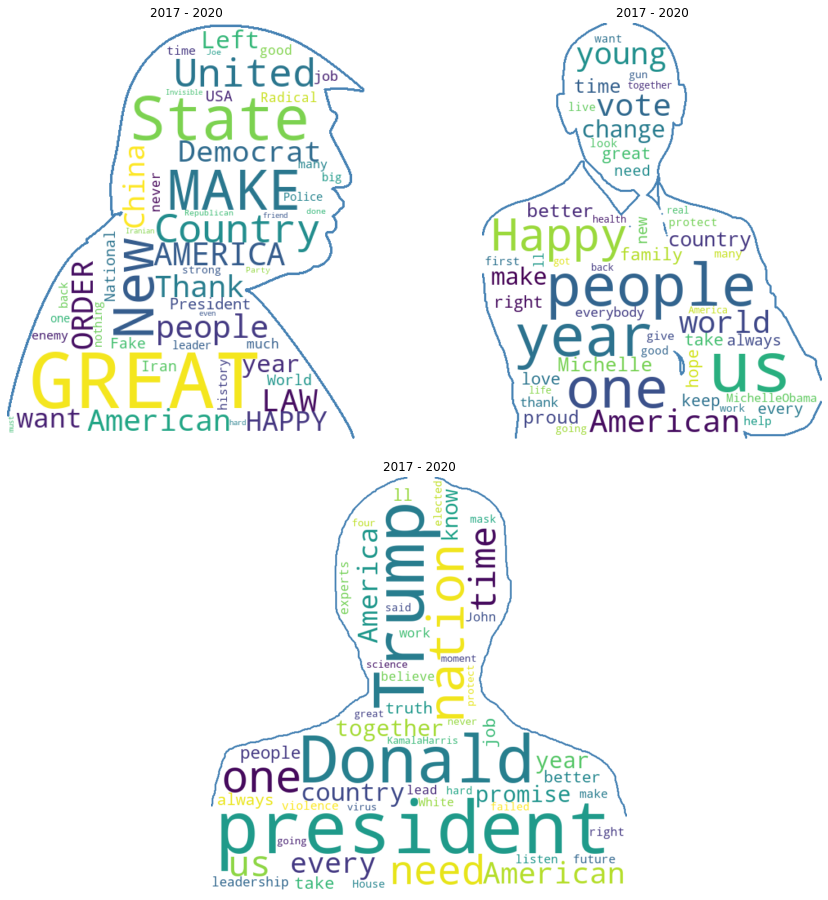

In [77]:
wordcloud_retweet(250, np.arange(2017, 2021, 1), np.arange(2017, 2021, 1), np.arange(2017, 2021, 1))

**Observation:**

The word clouds show that:
 
 - Trump's most retweeted tweets take a more nationalist tone given how often words such as 'America' 'great', 'military', 'China' and 'Iran' appear. His tweets concerning the arrest of 'A$AP Rocky' in Sweden also generated a lot of interests and was amongst his most retweeted tweets.
 - Obama's most retweeted tweets on the other hand typically revolve around talking up his love for 'Michelle Obama' and family.
 - Joe Biden's most retweeted tweets are themed around criticising Donaldo Trump in the lead up to the 2020 Presidential elections.

**3. What are the most popular hashtags used between Trump, Obama & Biden?**


**Let's build the wordcloud generator for most popular hashtags**

In [84]:
#Sort dataframes in order of most retweeted and drop tweets without text
obama_hashtag_df = obama_df.sort_values(by = ['HashTags'], ascending = False).dropna(subset = ['Text'])
trump_hashtag_df = trump_df.sort_values(by = ['HashTags'], ascending = False).dropna(subset = ['Text'])
biden_hashtag_df = biden_df.sort_values(by = ['HashTags'], ascending = False).dropna(subset = ['Text'])

#function will enable us to select the number of top hashtags to appear in first parameter as well as the range of
#years to look at for either Trump, Obama or Biden
year_range = np.arange(2008, 2021, 1)

def wordcloud_hashtag(top_number, trump_year = year_range, obama_year = year_range, biden_year = year_range):

    #Let's split the DataFrames into 3
    obama_hash_df = obama_hashtag_df[obama_hashtag_df.Year.isin(obama_year)].dropna(subset = ['HashTags'])
    trump_hash_df = trump_hashtag_df[trump_hashtag_df.Year.isin(trump_year)].dropna(subset = ['HashTags'])
    biden_hash_df = biden_hashtag_df[biden_hashtag_df.Year.isin(biden_year)].dropna(subset = ['HashTags'])
    
    #Loop through the rows and pull the hashtag mentions into a list
    obama_ls = [tweet for tweet in obama_hash_df.HashTags]
    trump_ls = [tweet for tweet in trump_hash_df.HashTags]
    biden_ls = [tweet for tweet in biden_hash_df.HashTags]

    #We have an issue where there are multiple mentions of a hashtag in a single tweet. We want to go ahead and split these up.
    obama_hashtags = []
    trump_hashtags = []
    biden_hashtags = []

    #The below loop will check the number of words in a list item, and append single word items to the appropriate list
    for hashtag in obama_ls:
        if len(hashtag.split(' ')) == 1:
            obama_hashtags.append(hashtag.split(' ')[0])
        elif len(hashtag.split(' ')) > 1:
            for hashtag_2 in hashtag.split(' '):
                obama_hashtags.append(hashtag_2)

    for hashtag in trump_ls:
        if len(hashtag.split(' ')) == 1:
            trump_hashtags.append(hashtag.split(' ')[0])
        elif len(hashtag.split(' ')) > 1:
            for hashtag_2 in hashtag.split(' '):
                trump_hashtags.append(hashtag_2)

    for hashtag in biden_ls:
        if len(hashtag.split(' ')) == 1:
            biden_hashtags.append(hashtag.split(' ')[0])
        elif len(hashtag.split(' ')) > 1:
            for hashtag_2 in hashtag.split(' '):
                biden_hashtags.append(hashtag_2)
    #Let's combine all the tweets into one big text and build a word cloud off the back of this
    obama_text = " ".join(tweet for tweet in obama_hashtags)
    trump_text = " ".join(tweet for tweet in trump_hashtags)
    biden_text = " ".join(tweet for tweet in biden_hashtags)

    #Generate masks for Obama and Trump
    mask_trump = np.array(Image.open('trump_3.png'))
    mask_obama = np.array(Image.open('obama_1.png'))
    mask_biden = np.array(Image.open('biden_edit.png'))

    #Create a stopword list
    stopwords = set(STOPWORDS)
    #Create a stopword list
    stopwords = set(STOPWORDS)
    stopwords.update(["will",'https', 'of', 'bo', 'a', 'well', 'way', 'keep', 'two', 'see', 're', 'today', 'week', 'far', 'now', 'act', 'even', 'second', 'one', 'back', 'tomorrow', 'background'])

    #Generate a word cloud image
    wordcloud_obama = WordCloud(background_color="white", stopwords = stopwords, max_words = top_number, mask=mask_obama, contour_width=3, contour_color='steelblue', collocations=False).generate(obama_text)
    wordcloud_trump = WordCloud(background_color="white", stopwords = stopwords, max_words = top_number, mask=mask_trump, contour_width=3, contour_color='steelblue', collocations=False).generate(trump_text)
    wordcloud_biden = WordCloud(background_color="white", stopwords = stopwords, max_words = top_number, mask=mask_biden, contour_width=3, contour_color='steelblue', collocations=False).generate(biden_text)

    #Display the generated image:
    plt.figure(figsize = (16, 16))
    gs = gridspec.GridSpec(4, 4)

    plt.subplot(gs[:2, :2])
    plt.imshow(wordcloud_trump, interpolation = 'bilinear')
    plt.axis('off')
    plt.title('{} - {}'.format(trump_year[0], trump_year[-1]))
    
    plt.subplot(gs[:2, 2:])
    plt.imshow(wordcloud_obama, interpolation = 'bilinear')
    plt.axis('off')
    plt.title('{} - {}'.format(obama_year[0], obama_year[-1]))
    
    plt.subplot(gs[2:4, 1:3])
    plt.imshow(wordcloud_biden, interpolation = 'bilinear')
    plt.axis('off')
    plt.title('{} - {}'.format(biden_year[0], biden_year[-1]))
    plt.show()

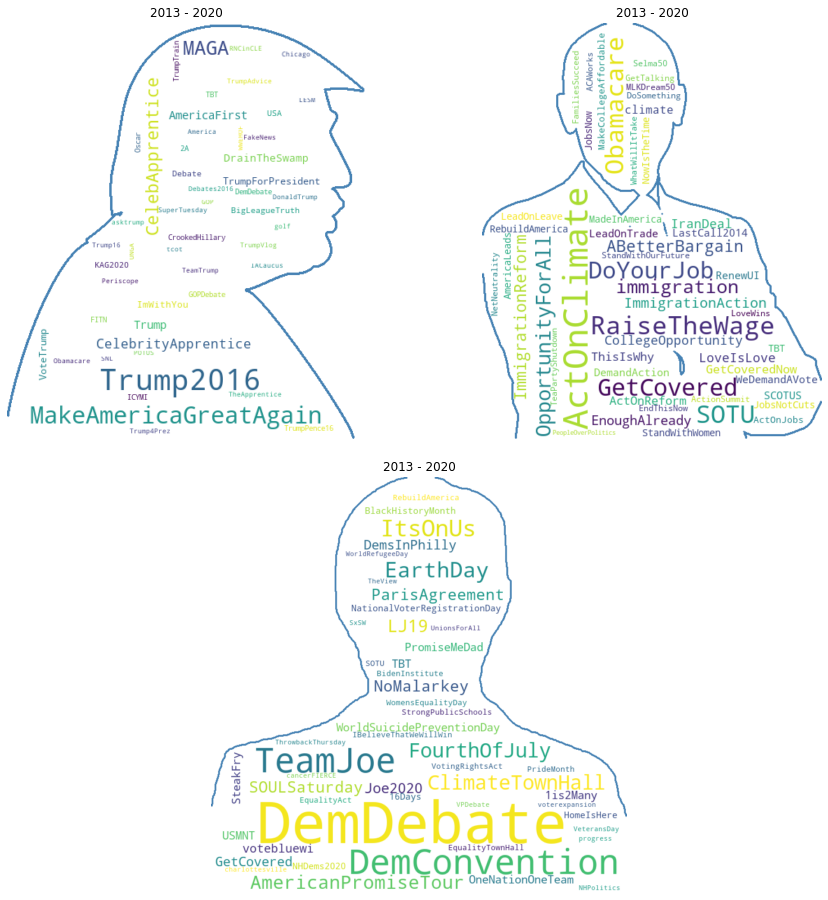

In [89]:
wordcloud_hashtag(50, np.arange(2013, 2021, 1), np.arange(2013, 2021, 1), np.arange(2013, 2021, 1))

**Observation:**

 - It isn't suprising to see that the most popular hashtags utilised by Trump take a nationalistic tone such as the use of 'MAGA'and 'KAG2020'. It's also interesting to see how often he utilised FakeNews and JobsNotMobs
 - Obama on the other hand placed a great deal of emphasis on pushing 'Climate Change' in addition to 'Raising the wage' and 'healthcare. It was also surprising to see Obama utilising immigration hashtags; deepdiving into these tweets further, the theme of these particular tweets were geared towards pushing immigration reform and a path for citizenship for undocumented settled immigrants in the USA.

**4. What are the most popular words used between Trump, Obama and Biden within their tweets?**

**Let's build a WordCloud function**

In [39]:
#Setting a global variable of the years in our dataset
year_range = np.arange(2008, 2021, 1)

#function will enable us to select the number of top retweets to appear in first parameter as well as the range of
#years to look at for either Trump, Obama or Biden
def wordcloud_tweet(top_number, trump_year = year_range, obama_year = year_range, biden_year = year_range):
    
    #Loop through the individual DataFrames and collect the tweets into a list of tweets
    obama_ls = [re.sub(r"http\S+", "", tweet).strip() for tweet in obama_df[obama_df.Year.isin(obama_year)].dropna(subset = ['Text']).Text]
    trump_ls = [re.sub(r"http\S+", "", tweet).strip() for tweet in trump_df[trump_df.Year.isin(trump_year)].dropna(subset = ['Text']).Text]
    biden_ls = [re.sub(r"http\S+", "", tweet).strip() for tweet in biden_df[biden_df.Year.isin(biden_year)].dropna(subset = ['Text']).Text]

    #Create empty lists to house the individual words from the individual tweets
    obama_series = []
    trump_series = []
    biden_series = []
    
    #loop through obama_ls, trump_ls and populate empty list with words
    for tweet in obama_ls:
        splits = tweet.split()
        for word in splits:
            obama_series.append(word.strip("—").strip("\"").strip(".").strip(":").strip(",").strip("?").strip("!").strip("?").strip("-").strip("\"").strip("!"))

    for tweet in trump_ls:
        splits = tweet.split()
        for word in splits:
            trump_series.append(word.strip("—").strip("\"").strip(".").strip(":").strip(",").strip("?").strip("!").strip("?").strip("-").strip("\"").strip("!"))

    for tweet in biden_ls:
        splits = tweet.split()
        for word in splits:
            biden_series.append(word.strip("—").strip("\"").strip(".").strip(":").strip(",").strip("?").strip("!").strip("?").strip("-").strip("\"").strip("!"))
    
    #Let's combine all the tweets into one big text and build a word cloud off the back of this
    obama_text = " ".join(word for word in obama_series)
    trump_text = " ".join(word for word in trump_series)
    biden_text = " ".join(word for word in biden_series)

    #Generate masks for Obama and Trump
    mask_obama = np.array(Image.open('obama_1.png'))
    mask_trump = np.array(Image.open('trump_3.png'))
    mask_biden = np.array(Image.open('biden_edit.png'))

    #Create a stopword list
    stopwords = set(STOPWORDS)
    stopwords.update(["will",'https', 'of', 'bo', 'a', 'well', 'way', 'keep', 'two', 'see', 're', 'today', 'week', 'far', 'now', 'act', 'even', 'second', 'one', 'back', 'tomorrow', 'background'])

    #Generate a word cloud image
    wordcloud_obama = WordCloud(background_color="white", stopwords = stopwords, max_words = top_number, mask=mask_obama, contour_width=3, contour_color='steelblue', collocations=False).generate(obama_text)
    wordcloud_trump = WordCloud(background_color="white", stopwords = stopwords, max_words = top_number, mask=mask_trump, contour_width=3, contour_color='steelblue', collocations=False).generate(trump_text)
    wordcloud_biden = WordCloud(background_color="white", stopwords = stopwords, max_words = top_number, mask=mask_biden, contour_width=3, contour_color='steelblue', collocations=False).generate(biden_text)

    #Display the generated image:
    plt.figure(figsize = (16, 16))
    gs = gridspec.GridSpec(4, 4)

    plt.subplot(gs[:2, :2])
    plt.imshow(wordcloud_trump, interpolation = 'bilinear')
    plt.axis('off')
    plt.title('{} - {}'.format(trump_year[0], trump_year[-1]))

    plt.subplot(gs[:2, 2:])
    plt.imshow(wordcloud_obama, interpolation = 'bilinear')
    plt.axis('off')
    plt.title('{} - {}'.format(obama_year[0], obama_year[-1]))

    plt.subplot(gs[2:4, 1:3])
    plt.imshow(wordcloud_biden, interpolation = 'bilinear')
    plt.axis('off')
    plt.title('{} - {}'.format(biden_year[0], biden_year[-1]))
    plt.show()

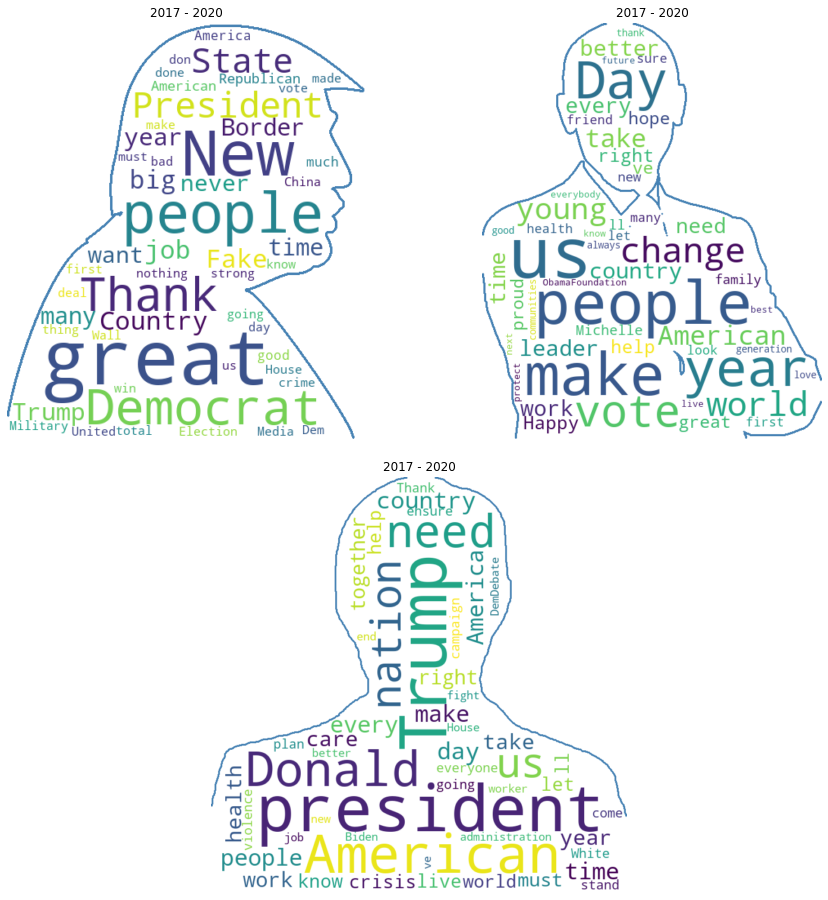

In [55]:
wordcloud_tweet(50, np.arange(2017, 2021, 1), np.arange(2017, 2021, 1), np.arange(2017, 2021, 1))

In [41]:
user_names_df_clean.to_csv('biden_trump_obama_clean_2008_2020', index = False)

### 5. Export DataFrame to gSheet

In [42]:
#Import gspread and ensure credentials are provided
import gspread
gc = gspread.oauth()

In [43]:
#Below code will create a gsheet and aworksheet
sh = gc.create("Obama_Trump_Biden_2008_2020_Tweets")
wks = gc.open("Obama_Trump_Biden_2008_2020_Tweets").sheet1

In [44]:
#Code taken from https://www.danielecook.com/from-pandas-to-google-sheets/

#This function will enable the pushing of pandas dataframe into a google sheet

def iter_pd(df):
    for val in df.columns:
        yield val
    for row in df.to_numpy():
        for val in row:
            if pd.isna(val):
                yield ""
            else:
                yield val

def pandas_to_sheets(pandas_df, sheet, clear = True):
    # Updates all values in a workbook to match a pandas dataframe
    if clear:
        sheet.clear()
    (row, col) = pandas_df.shape
    cells = sheet.range("A1:{}".format(gspread.utils.rowcol_to_a1(row + 1, col)))
    for cell, val in zip(cells, iter_pd(pandas_df)):
        cell.value = val
    sheet.update_cells(cells)

In [45]:
#We'll need to convert the DateTime column back into a string object otherwise as DateTime format is not JSON serializable
#Needs to be JSON serializable in order to push DataFrame into GoogleSheets
user_names_df_clean_gspread = user_names_df_clean.copy()
user_names_df_clean_gspread.Date = user_names_df_clean_gspread.Date.dt.strftime('%Y-%m-%d %H:%M:%S')

In [46]:
#In order to be able to have the Date readable in GoogleSheets, we'll need to split the Date and Time into two separate columns

#We'll need to reformat the Tweet_id in strings, given how Google Sheets round up the last 4 digits
#because Javascript cannot support numbers with > 53-bits

#This will create series object by splitting the date and time into 2 separate columns
date_split = user_names_df_clean_gspread['Date'].str.split(" ")

#Two columns will be created to host the Date and Time of the tweets
user_names_df_clean_gspread['Date'] = date_split.str.get(0)
user_names_df_clean_gspread['Time'] = date_split.str.get(1)

#Convert 'Tweet_id' column into strings
user_names_df_clean_gspread['Tweet_id'] = user_names_df_clean_gspread.Tweet_id.astype(str)

#Check to see if it works
user_names_df_clean_gspread.head()

,User,Tweet_id,Text,Date,Favorites,Retweets,Mentions,HashTags,Year,Month,Day,Hour,Time
0,JoeBiden,1305648774157565952,".@realDonaldTrump, you know what’s actually threatening our suburbs? Wildfires. Floods. Hurricanes. We need to act on climate. Now.",2020-09-14,35588,206086,@realDonaldTrump,NaN,2020,9,14,23,23:25:00
1,JoeBiden,1305608509229207552,Science knows.,2020-09-14,24930,115776,NaN,NaN,2020,9,14,20,20:45:00
2,JoeBiden,1305605992483258371,"Folks, it all comes down to this. We have just 50 days until the most important election of our lifetimes. Make a plan to have your voice heard this November.",2020-09-14,7974,31128,NaN,NaN,2020,9,14,20,20:35:00
3,JoeBiden,1305578058326343683,Amy Poehler and @MayaRudolph know a thing or two about @HillaryClinton and @KamalaHarris — and I can't wait to see what they have in store for tonight's grassroots fundraiser. Chip in now to reserve your ticket: https://joe.link/3iqquYu,2020-09-14,3479,15652,@MayaRudolph @HillaryClinton @KamalaHarris,NaN,2020,9,14,18,18:44:00
4,JoeBiden,1305559162080747525,Climate change is the existential challenge that will define our future as a country. Tune in as I discuss the wildfires up and down the West Coast — and how I'll tackle the climate crisis head-on and create millions of good-paying jobs:,2020-09-14,4318,13714,NaN,NaN,2020,9,14,17,17:28:55


In [47]:
#Push data into google sheets!
pandas_to_sheets(user_names_df_clean_gspread, wks)

In [48]:
user_names_df_clean_gspread.to_csv('biden_trump_obama_clean_2008_2020_gspread.csv', index = False)

### 6. Export DataFrame to CSV for DataStudio usage

In [49]:
#We'll need to surround the Tweet_id in strings, given how Google Sheets round up the last 4 digits
#because Javascript cannot support numbers with > 53-bits

user_names_df_clean_datastudio = user_names_df_clean_gspread.copy()
user_names_df_clean_datastudio['Tweet_id'] = "'" + user_names_df_clean_datastudio.Tweet_id + "'"

In [50]:
user_names_df_clean_datastudio.head()

,User,Tweet_id,Text,Date,Favorites,Retweets,Mentions,HashTags,Year,Month,Day,Hour,Time
0,JoeBiden,'1305648774157565952',".@realDonaldTrump, you know what’s actually threatening our suburbs? Wildfires. Floods. Hurricanes. We need to act on climate. Now.",2020-09-14,35588,206086,@realDonaldTrump,NaN,2020,9,14,23,23:25:00
1,JoeBiden,'1305608509229207552',Science knows.,2020-09-14,24930,115776,NaN,NaN,2020,9,14,20,20:45:00
2,JoeBiden,'1305605992483258371',"Folks, it all comes down to this. We have just 50 days until the most important election of our lifetimes. Make a plan to have your voice heard this November.",2020-09-14,7974,31128,NaN,NaN,2020,9,14,20,20:35:00
3,JoeBiden,'1305578058326343683',Amy Poehler and @MayaRudolph know a thing or two about @HillaryClinton and @KamalaHarris — and I can't wait to see what they have in store for tonight's grassroots fundraiser. Chip in now to reserve your ticket: https://joe.link/3iqquYu,2020-09-14,3479,15652,@MayaRudolph @HillaryClinton @KamalaHarris,NaN,2020,9,14,18,18:44:00
4,JoeBiden,'1305559162080747525',Climate change is the existential challenge that will define our future as a country. Tune in as I discuss the wildfires up and down the West Coast — and how I'll tackle the climate crisis head-on and create millions of good-paying jobs:,2020-09-14,4318,13714,NaN,NaN,2020,9,14,17,17:28:55


In [51]:
user_names_df_clean_datastudio.to_csv('biden_trump_obama_clean_2008_2020_datastudio.csv', index = False)

### 7. Export original clean DataFrame to CSV

In [52]:
user_names_df_clean.to_csv('biden_trump_obama_clean_2008_2020_original.csv', index = False)

In [53]:
user_names_df_clean[user_names_df_clean.Tweet_id.isin([266031293945503744])]

,User,Tweet_id,Text,Date,Favorites,Retweets,Mentions,HashTags,Year,Month,Day,Hour
1059,BarackObama,266031293945503744,Four more years.,2012-11-07 04:16:18,835562,562463,NaN,NaN,2012,11,7,4


In [61]:
pd.read_csv('biden_trump_obama_clean_2008_2020').Date.max()

'2020-09-14 23:25:00'